# Optical Flow Gradients

The following jupyter notebook would explore the following:
1. Load a small dataset using the `data_tuple.csv` and data.
2. See some transformations required to resize the images.
3. Calculate using TVL-1 algorithm, the gradient flows.
4. Take a look at the images with their corresponding labels


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from summarytools import dfSummary
import cv2
from tqdm import tqdm

In [3]:
# See of Data path exists
DATA_PATH = os.path.join(os.getcwd(), os.pardir, "data", "MultiCamFall")
print(os.path.exists(DATA_PATH))

VIDEO_PATH = os.path.join(DATA_PATH, "dataset", "dataset")
print(os.path.exists(VIDEO_PATH))

True
True


In [4]:
#lets obtain the metadata file
df_metadata = pd.read_csv(os.path.join(DATA_PATH, "data_tuple3.csv"))
df_metadata.loc[df_metadata["cam"] == 55, "cam"] = 3.0
dfSummary(df_metadata)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,chute[float64],Mean (sd) : 12.6 (7.0)min < med < max:1.0 < 12.0 < 23.0IQR (CV) : 13.0 (1.8),23 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACrUlEQVR4nO3cwYraUBSA4ZNmlIxCggi68wUKXbj0IfqwfYQufALfwJ0gEjEzwRgzi0EYSpvEe3ObnOT/9lEXP3XO6b16RVEI0HXf2v4AQB0vbX8AdIfnea8iMrZ4iWtRFO9NfZ6vCBUi8hnpfD7/GYbhzPQ1zufzyfO8Xy5iJVQ8jMMwnG02m/coitJnH47jONhut7Pj8TgWEUKFW1EUpYvF4s3w8ddGP8wXDFNQgVChAl/9aEye5yMRCT3PM3m8dGNAqGhEkiSjLMt+rFYr3/f9p4exqo0BoaIR1+v1JQiCyXq9TpfL5emZZ+tsDAgVjZpOp6Zbg9KNAcMUVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlSo/J8py+sJzq4mYFhKQ7W9nuDyagKGpepfVOPrCa6vJmBYah1Ksbie4OxqAoaFYQoqECpUcHoe1fJqgojSrQGbkuY5C9X2aoKIzq0BmxI3nIVqczVBRPXWgE2JA86volhcTRBRvDVgU9IshimoQKhQodO3UF3+oEEVi8k9vN/vI9P3xd91NlTXP2hQxmZyz7IsyPP8e5qmv0XE9G9z/KGzobr+QYMKxpP7fr+f7Xa7ye128w3eF//Q2VAfXP2gQR0mk/vpdGJqd4BhCioQKlTo/Fe/KcuNQWuT+1DPR1TpZai2G4O2Jvehno+oo5eh2p4zaGtyH/D5iEq9DPXBdGPQ9uQ+1PMRZRimoAKhQoVef/UPkcXWoNNnFAi1R2y2Bl0/o0CoPWKzNej6GQVC7SGTrUHbm44qDFNQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKtS73xXEcPPvCl8slEBFJkiQ4HA6T//m81vfW+rltn6/T1we4BMahbQjBRwAAAABJRU5ErkJggg=="">",0(0.0%)
2,cam[float64],1. 1.02. 2.03. 3.04. 4.05. 5.06. 6.07. 7.08. 8.0,69 (12.5%)69 (12.5%)69 (12.5%)69 (12.5%)69 (12.5%)69 (12.5%)69 (12.5%)69 (12.5%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAC4CAYAAAD0WZ4UAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACoklEQVR4nO3cQWrbUABF0a9iQjORMAYvxovoYrsI7cYYa9CETNxBh+0s4gbccxbwyeAiI/FfpsfjMaDw7av/AP4fYiMjNjJiIyM2MmIjM40xXscYLzud9/F4PN52OosnczidTj/meT7ucdi2bbdpmn4Kjn85zPN8vFwub8uyvH/moPv9/n1d1+P1en0ZY4iNvxzGGGNZlvfz+fxrh/NedziDJ+UFgYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjcxhjD/Xgz570B5n8NwO27bd1nU9jh2uB23bdhtjfHz+z+IZuRZOZvLvF6h4spExeCFj8ELG4IWMj7pkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkDF7IGLyQcS2cjMELGS8IZPyMkrGuImNdRca6iowXBDJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjLWVWSsq8i4Fk7GuoqMJxsZgxcyBi9kDF7I+KhLRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGxuCFjMELGdfCyRi8kPGCQMbPKBnrKjLWVWSsq8h4QSAjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiNjXUXGuoqMa+FkrKvIeLKRMXghY/BCxuCFjI+6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGxrqKjHUVGRsEMtZVZDzZyFhXkbGuImNdRcZHXTJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjIGL2QMXsi4Fk7G4IWMJxsZgxcyBi9kDF7I+KhLRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkrKvIWFeRsUEgY11FxgsCGbGRERsZsZERG5nfLZWuhBU4rK0AAAAASUVORK5CYII="">",0(0.0%)
3,start[float64],Mean (sd) : 745.9 (613.7)min < med < max:240.0 < 606.0 < 4166.0IQR (CV) : 288.5 (1.2),351 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACYUlEQVR4nO3dPY7aUBSG4XP5iz0gA3IGOpoUdBSULGIWmy0gsQB6irQIa2SEA4E4ThOiSJEAX4uED71PzbmmeIXt5uCKojDg0dX+9xcAbtG49gHnXGhmLc/zj0VR7D1ngd8uhuqcC+M4fouiqO9z+Ha7fXfOfSZWVHXtF7UVRVF/Npvtu93uoczBaZoGi8WinyRJy8wIFZVcvfWbmXW73cNgMPjqcX7oMQP8hZcpSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSLhppY+vPM+bZhY553yPYBsgzOyOoWZZ1jydTpPRaFSv1+ulFqydsQ0QZ3cL9Xg8NoIgeJlOp4fhcPhedp5tgPjTXW/9Zmbtdtt3E6AZ2wDxCy9TkECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokHD3lT5VVNwGyCbAJ/KwoVbdBsgmwOfysKFW2QaYpmkwn88HSZJ8dM5tfb8CkT+Ohw31zGcbILtZn8/Dh+qD3azP5ylDPWM3aznOudDMWhWOqJnZD8/Zi49aTx0qbuecC+M4fouiqO8zn+d5M8uyT51OZ1Wr1U5l5689at0UapqmQdkL73a7wMwsy7JgvV6//Mv5qtdO0zTI87xh1f4oQ03U6XReJ5PJ9zAMv5Ud3mw2wWq1eh2Px196vd6uzOx+v/+wXC4vPmr9BG325f/zo2PcAAAAAElFTkSuQmCC"">",0(0.0%)
4,end[float64],Mean (sd) : 775.9 (613.7)min < med < max:270.0 < 636.0 < 4196.0IQR (CV) : 288.5 (1.3),351 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGC

In [5]:
df_metadata.head(12)

,chute,cam,start,end,label
0,1.0,1.0,1052.0,1082.0,0.0
1,1.0,1.0,1083.0,1113.0,1.0
2,1.0,1.0,1114.0,1144.0,0.0
3,1.0,2.0,1052.0,1082.0,0.0
4,1.0,2.0,1083.0,1113.0,1.0
5,1.0,2.0,1114.0,1144.0,0.0
6,1.0,3.0,1057.0,1087.0,0.0
7,1.0,3.0,1088.0,1118.0,1.0
8,1.0,3.0,1119.0,1149.0,0.0
9,1.0,4.0,1053.0,1083.0,0.0


## 3. Lets create functions to obtain the frames.

In [ ]:
def get_row_data(row:pd.DataFrame) -> \
    tuple[list[np.ndarray], list[np.ndarray], list[np.ndarray]]:
    """
    Extract a sequence of frames from a video file within the specified frame range.
    It also would retrieve the corresponding Fall/No fall event, for each
    specific frame, as well as frame time stamps in ms.

    Args:
        chute (int): The chute number identifying the video scenario
        cam (int): The camera number identifying the video perspective
        start (int): The starting frame number (inclusive)
        end (int): The ending frame number (exclusive)
        label (float): Referring to a Fall/No fall event. 1.0 or 0.0.

    Returns:
        list[np.ndarray]: A list of numpy arrays containing the video frames
        in BGR format
        list[np.ndarray]: A list of numpy arrays containing the appropiate
        label for each specific frame.
        list[np.ndarray]: A list of ints containing the timestamps for
        each of the frames.
    """
    
    #Obtain the important information
    chute = int(row['chute'])
    cam = int(row['cam'])
    start = int(row['start'])
    end = int(row['end'])
    label = int(row["label"])

    #Printing the message has started
    print(f"Scenario: {chute}, camera: {cam},\
        start: {start}, end {end}, label: {label}")
    print("Obtaining data....")

    # Read the video path to access the video files
    video_path = os.path.join(VIDEO_PATH, f"chute{chute:02d}", f"cam{cam}.avi")
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    #Setup the lists to append frames, labels, and frames_ts
    frame_no = 1
    frames = []
    labels = []
    frames_ts = []

    # Read the first frame
    ret, frame = cap.read()

    # Loop over the frames
    while ret:

        # Skip frames outside of the start and end frames
        if frame_no < start - 1 or frame_no > end:
            ret, frame = cap.read()
            frame_no += 1
            continue

        if start - 1 <= frame_no < end:
            frame_timestamp_ms = int(frame_no / fps * 1000)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, (224, 224))
            frames.append(frame)
            frames_ts.append(frame_timestamp_ms)
        
        # Follow with the next frame
        frame_no += 1

        # Read the next frame
        ret, frame = cap.read()

    # Release the video capture
    cap.release()

    #Assign the proper labels for Fall/No fall
    if label == 1:
        labels.append(np.ones(len(frames)))
    elif label == 0:
        labels.append(np.zeros(len(frames)))

    print("Data obtained.")

    return np.array(frames, dtype=np.float32), \
        np.array(labels, dtype=np.float32).reshape(-1, 1),\
        np.array(frames_ts, dtype=np.float32).reshape(-1, 1)


In [7]:
#Obtain a mini sample for testing
df_sample = df_metadata[(df_metadata['chute'] == 2.0) & (df_metadata['cam'] == 1)]

# Assign different variables that simulate X, Y, only for sample
X_samp = []
Y_samp = []
ts_samp = []

# Lets obtain all of the data
for i in range(len(df_metadata)):
    row = df_metadata.iloc[i]
    frames, labels, frames_ts = get_row_data(row)

    #Append the frames, labels and frames_ts
    X_samp.append(frames)
    Y_samp.append(labels)
    ts_samp.append(frames_ts)

    # This is for testing purposes. We know pre-fall-post-fall
    if i == 2:
        break


Scenario: 1, camera: 1,        start: 1052, end 1082, label: 0
Obtaining data....
Data obtained.
Scenario: 1, camera: 1,        start: 1083, end 1113, label: 1
Obtaining data....
Data obtained.
Scenario: 1, camera: 1,        start: 1114, end 1144, label: 0
Obtaining data....
Data obtained.


In [8]:
### Lets now np.concatanate against zero axis to obtain dataset
X_samp = np.concatenate(X_samp, axis=0)
Y_samp = np.concatenate(Y_samp, axis=0)
ts_samp = np.concatenate(ts_samp, axis=0)

In [9]:
print(X_samp.shape)
print(Y_samp.shape)
print(ts_samp.shape)

print(X_samp.dtype)
print(Y_samp.dtype)
print(ts_samp.dtype)

(90, 224, 224, 3)
(90, 1)
(90, 1)
float32
float32
float32


In [10]:
X_samp[0]

array([[[32., 35., 32.],
        [39., 39., 36.],
        [48., 60., 39.],
        ...,
        [20., 22., 17.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  1.]],

       [[34., 31., 30.],
        [42., 37., 36.],
        [34., 41., 23.],
        ...,
        [20., 22., 16.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  1.]],

       [[37., 30., 30.],
        [36., 26., 30.],
        [38., 40., 24.],
        ...,
        [20., 22., 16.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       ...,

       [[33., 31., 29.],
        [36., 32., 24.],
        [27., 34., 14.],
        ...,
        [16., 18., 15.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[32., 31., 26.],
        [32., 28., 20.],
        [27., 33., 17.],
        ...,
        [16., 19., 15.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[29., 29., 21.],
        [35., 31., 23.],
        [24., 30., 18.],
        ...,
        [16., 18., 15.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]]

## 4. Create a function that takes a tuple of NHWC, and calculate optical flow gradients

In [ ]:
import cv2
import numpy as np

def compute_optical_flow(batch_frames:np.ndarray) -> np.ndarray:
    """
    Computes the TV-L1 optical flow for a batch of consecutive image frames.
    
    Args:
        batch_frames (numpy.ndarray): 4D NumPy array of shape (batch_size, height, width, 3)
                                      representing a batch of RGB images.
    
    Returns:
        numpy.ndarray: 4D array of shape (batch_size-1, height, width, 2) with optical flow vectors.
    """
    batch_size, height, width, _ = batch_frames.shape

    # Convert batch to grayscale (required for optical flow computation)
    batch_gray = np.array([cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY) for frame in batch_frames])
    rgbx_images = []
    rgby_images = []
    rgb_flow_images = []

    for i in tqdm(range(batch_size - 1)):
        #flow = optical_flow.calc(batch_gray[i], batch_gray[i + 1], None)
        flow = cv2.calcOpticalFlowFarneback(batch_gray[i], batch_gray[i + 1], None,\
            pyr_scale=0.8, levels=3, winsize=10, iterations=3, poly_n=7, poly_sigma=1.1, flags=0)
        
        #This is experimental; to see the flow
        hsvx = np.zeros((height, width, 3), dtype=np.uint8)
        hsvy = np.zeros((height, width, 3), dtype=np.uint8)
        hsv = np.zeros((height, width, 3), dtype=np.uint8)

        # Get the flow x and flow y
        flow_x = flow[:, :, 0]
        flow_y = flow[:, : ,1]

        #Set the Hue and saturation components to 1-
        hsvx[..., 0] = 10
        hsvx[..., 1] = 10
        hsvy[..., 0] = 10
        hsvy[..., 1] = 10

        #Get the third channel of hsvx and hsvy to normalize
        hsvx[...,2] = cv2.normalize(flow_x,None,0,255,cv2.NORM_MINMAX)
        hsvy[...,2] = cv2.normalize(flow_y,None,0,255,cv2.NORM_MINMAX)

        #Append the RGB images
        rgbx_images.append(cv2.cvtColor(hsvx, cv2.COLOR_HSV2BGR))
        rgby_images.append(cv2.cvtColor(hsvy, cv2.COLOR_HSV2BGR))

        # THIS IS FOR OTHER IMAGES
        hsv[...,1] = 255  # Full saturation

        # Compute magnitude and angle
        magnitude, angle = cv2.cartToPolar(flow_x, flow_y)

        # Map angle to Hue (0-180)
        hsv[...,0] = angle * 180 / np.pi / 2

        # Normalize magnitude to [0,255] and map to Value
        hsv[...,2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)

        # Convert to BGR for visualization
        rgb_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
        rgb_flow_images.append(rgb_flow)
    
    return rgbx_images, rgby_images, rgb_flow_images


In [66]:
#Obtain the X_samp flow
rgbx_images, rgby_images, rgb_flow_images = compute_optical_flow(X_samp)

  0%|          | 0/89 [00:00<?, ?it/s]

100%|██████████| 89/89 [00:01<00:00, 65.21it/s]


### 5. Now with the optical gradient flows, lets see them

(224, 224, 3)


(-0.5, 223.5, 223.5, -0.5)

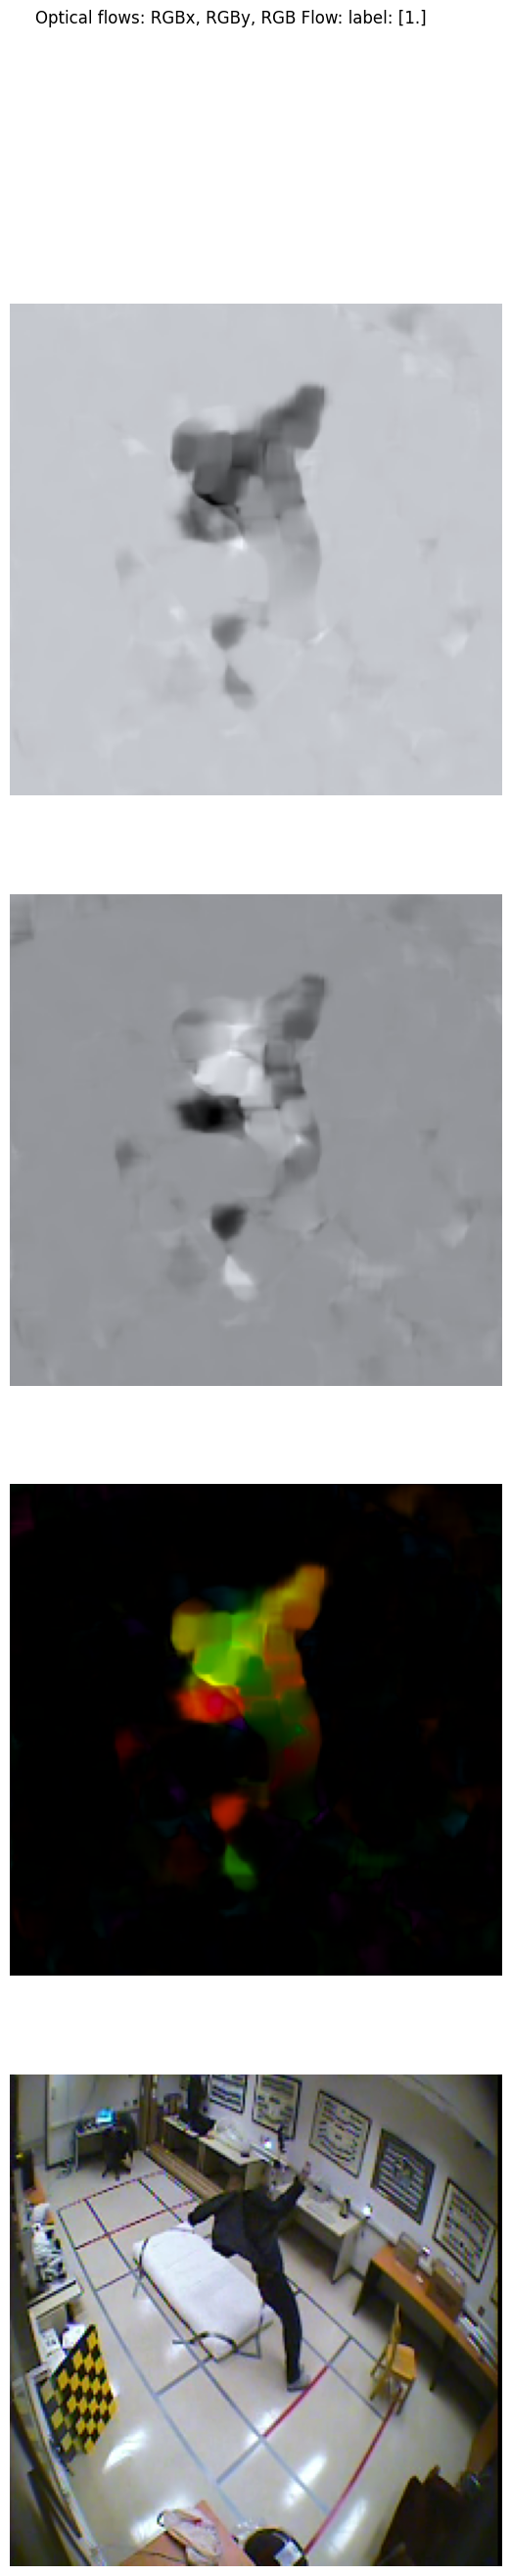

In [71]:
plot_idx = 45
print(rgbx_images[plot_idx].shape)
plt.figure(figsize=(20,30))
plt.suptitle(f"Optical flows: RGBx, RGBy, RGB Flow: label: {Y_samp[plot_idx]}")
plt.subplot(4,1,1)
plt.imshow(rgbx_images[plot_idx])
plt.axis("off")
plt.subplot(4,1,2)
plt.imshow(rgby_images[plot_idx])
plt.axis("off")
plt.subplot(4,1,3)
plt.imshow(rgb_flow_images[plot_idx])
plt.axis("off")
plt.subplot(4,1,4)
plt.imshow(X_samp[plot_idx].astype(np.uint8))
plt.axis("off")